# Analyzing Transportation Patterns Using Chicago Taxi Trip and Chicago Rideshare for Urban Planning Insights

Urban planning is an important aspect of designing cities to meet the infrastructure needed to support the livelihood of tens of millions of residents. Transportation in particular has a critical impact on people’s decision to accept employment, how they spend their time, places they visit, and even business locations. This exploration of Chicago taxi and ride share service data will provide an insight on traffic conditions, travel expenses, and hotspots for visitation in the city which can be used for city planning purposes.

**Group Members**
1. Monika Phuengmak
2. Winni Tai 
3. Syeda Aqeel

## 1. Problem Definition
This project aims to analyze Chicago’s taxi and rideshare data from 2018 to 2023 to generate actionable insights that support urban planning, enhance traffic management, and optimize transportation services. By identifying peak demand zones, assessing traffic congestion effects on trip durations, and analyzing fare trends across variables such as time, location, and service type, the project seeks to provide data-driven recommendations to improve mobility, reduce congestion, and better meet the transportation needs of Chicago’s residents and visitors.

## 2. Data Sources
- Chicago Taxi Trips from 2013 to 2023: [link](https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data)
- Chicago Transportation Network Providers Trip: from 2018 to 2022: [link](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2018-2022-/m6dm-c72p/about_data)
- Chicago Transportation Network Providers Trip: from 2023 to present: [link](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2023-/n26f-ihde/about_data)
- Chicago Community Area: [link](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

### Chicago Taxi Trips

This dataset reflects taxi trips reported to the City of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number. Census Tracts are suppressed in some cases for privacy. Due to the data reporting process, not all trips are reported but the City believes that most are.

**Columns in this dataset**

|Column name|Description|Type|
|--|--|--|
|trip_id|A unique identifier for the trip. Initially called unique_key, but it will be renamed to trip_id.|String|
|taxi_id|A unique identifier for the taxi.|String|
|trip_start_timestamp|Date and time when the trip started, rounded to the nearest 15 minutes.|Timestamp|
|trip_end_timestamp|Date and time when the trip ended, rounded to the nearest 15 minutes.|Timestamp|
|trip_seconds|Duration of the trip in seconds.|Integer|
|trip_miles|Distance of the trip in miles.|Integer|
|pickup_census_tract|The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.|Number|
|dropoff_census_tract|The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.|Number|
|pickup_community_area|The Community Area where the trip began. This column will be blank for locations outside Chicago.|Integer|
|dropoff_community_area|The Community Area where the trip ended. This column will be blank for locations outside Chicago.|Integer|
|fare|The fare for the trip.|Integer|
|tips|The tip for the trip. Cash tips generally will not be recorded.|Integer|
|tolls|The tolls for the trip.|Integer|
|extras|Extra charges for the trip. This generally includes airport surcharges, late-night or rush hour surcharges, credit card processing fee, and other surcharges.|Integer|
|trip_total|Total cost of the trip calculated from are, tips, tolls, and extras.|Integer|
|payment_type|Type of payment for the trip.|String|
|company|The taxi company.|String|
|pickup_latitude|The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|pickup_longitude|The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|pickup_location|The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|String|
|dropoff_latitude|The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|dropoff_longitude|The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|dropoff_location|The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|String|

### Chicago Community Area
Chicago City has 77 community areas in total.

**Columns in this dataset**
|Column name|Description|Type|
|the_geom|--|--|
|PERIMETER|--|--|
|AREA|--|--|
|COMAREA_|--|--|
|COMAREA_ID|--|--|
|AREA_NUMBE|--|--|
|COMMUNITY|--|--|
|AREA_NUM_1|--|--|
|SHAPE_AREA|--|--|
|SHAPE_LEN|--|--|

In [17]:
community_area_schema = StructType([StructField('the_geom', StringType(), True), 
                                    StructField('PERIMETER', StringType(), True), 
                                    StructField('AREA', StringType(), True), 
                                    StructField('COMAREA_', StringType(), True), 
                                    StructField('COMAREA_ID', StringType(), True), 
                                    StructField('AREA_NUMBE', IntegerType(), True), 
                                    StructField('COMMUNITY', StringType(), True), 
                                    StructField('AREA_NUM_1', StringType(), True), 
                                    StructField('SHAPE_AREA', StringType(), True), 
                                    StructField('SHAPE_LEN', StringType(), True)])

spark.read.format("csv").option("header", "true").csv("gs://qstba843-team2/data/chicago-taxi-trip/community_area.csv")

StructType([StructField('the_geom', StringType(), True), StructField('PERIMETER', StringType(), True), StructField('AREA', StringType(), True), StructField('COMAREA_', StringType(), True), StructField('COMAREA_ID', StringType(), True), StructField('AREA_NUMBE', StringType(), True), StructField('COMMUNITY', StringType(), True), StructField('AREA_NUM_1', StringType(), True), StructField('SHAPE_AREA', StringType(), True), StructField('SHAPE_LEN', StringType(), True)])

## 3. Data Cleaning

Download data from Google Cloud Bucket:

In [1]:
# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
url = "gs://" + bucket + "/data/chicago-taxi-trip/chicago-taxi-0000000000*"

In [2]:
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DoubleType,
                               IntegerType,
                               StringType,
                               TimestampType)

taxi_schema = StructType([StructField('unique_key', StringType(), True),
                StructField('taxi_id', StringType(), True),
                StructField('trip_start_timestamp', TimestampType(), True), 
                StructField('trip_end_timestamp', TimestampType(), True), 
                StructField('trip_seconds', IntegerType(), True), 
                StructField('trip_miles', IntegerType(), True), 
                StructField('pickup_census_tract', StringType(), True), 
                StructField('dropoff_census_tract', StringType(), True), 
                StructField('pickup_community_area', IntegerType(), True), 
                StructField('dropoff_community_area', IntegerType(), True), 
                StructField('fare', IntegerType(), True), 
                StructField('tips', IntegerType(), True), 
                StructField('tolls', IntegerType(), True), 
                StructField('extras', IntegerType(), True), 
                StructField('trip_total', IntegerType(), True), 
                StructField('payment_type', StringType(), True), 
                StructField('company', StringType(), True), 
                StructField('pickup_latitude', StringType(), True), 
                StructField('pickup_longitude', StringType(), True), 
                StructField('pickup_location', StringType(), True), 
                StructField('dropoff_latitude', StringType(), True), 
                StructField('dropoff_longitude', StringType(), True), 
                StructField('dropoff_location', StringType(), True)])

taxi_all_years = spark.read.format("csv").option("header", "true").schema(taxi_schema).csv(url)

In [3]:
taxi_all_years.printSchema()

root
 |-- unique_key: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: integer (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: string (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: integer (nullable = true)
 |-- tips: integer (nullable = true)
 |-- tolls: integer (nullable = true)
 |-- extras: integer (nullable = true)
 |-- trip_total: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullabl

Inspect the first 10 rows of the dataset:

In [4]:
taxi_all_years.limit(10).toPandas()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,5003bdd51918a9b5a52134096663b4d7e02395c5,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-02-25 14:15:00,2013-02-25 14:15:00,120,0.0,None,None,NaN,NaN,...,NaN,NaN,Cash,None,None,None,None,None,None,None
1,720534d264001b2644f682755b294067fdf1da21,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-02 08:15:00,2013-06-02 08:15:00,60,NaN,None,None,NaN,NaN,...,NaN,NaN,Cash,None,None,None,None,None,None,None
2,515b9a6d5234a4d1fb559dca27b3e1cc541a342d,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-24 06:15:00,2013-06-24 06:15:00,60,NaN,None,None,1.0,77.0,...,NaN,NaN,Cash,None,42.009622881,-87.670166857,POINT (-87.67016685690001 42.0096228806),41.9867118,-87.663416405,POINT (-87.6634164054 41.9867117999)
3,8afd48d966bf464e93127f43b72a8e405596a8eb,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,61560,0.0,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None
4,fe73a44f01fdd2a3c740a01f53e97ec2ced93455,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,60900,0.0,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None
5,e3f992b350122d006ab02bade16f0db85a77efad,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,60780,0.0,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None
6,90e0d51d20f84ddbeece8c05a21ea031c8812a01,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,0,0.0,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None
7,ff4a3c7cd1bd70b906eb1ca91d620bfd215dd27e,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,0,0.0,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None
8,f927054758d789285e2ef73b21751e358bd5f64e,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,60,NaN,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None
9,95934109e937217408cc935b332e9ee3326b4875,842e2b1cd011fab01b6cc042f40c5941798405df1b3b02...,2013-02-17 06:00:00,2013-02-17 06:15:00,660,NaN,None,None,NaN,NaN,...,0.0,0.0,Cash,None,None,None,None,None,None,None


#### Filter only data between 2018 and 2023

In [5]:
from pyspark.sql.functions import year, col

start_year = (year(col("trip_start_timestamp")) >= 2018)
end_year = (year(col("trip_end_timestamp")) <= 2023)
taxi_trip = taxi_all_years.filter(start_year & end_year)

In [6]:
taxi_trip.limit(10).toPandas()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,5290649a65d2501064d8d39c53e0c1206347c67b,883e86111c7bebb7bdd41cbcac8ebbcc1172fe7464b90f...,2019-12-13 09:30:00,2019-12-13 09:45:00,404,NaN,None,None,NaN,NaN,...,1,NaN,Cash,Flash Cab,None,None,None,None,None,None
1,53b7935d29bfae1ce438d7cd29fd23bf6541ca41,5e00ac77728ae1790a517495300680a2ff69fe9a569218...,2019-12-18 14:00:00,2019-12-18 14:00:00,37,0.0,None,None,NaN,NaN,...,0,NaN,Cash,Flash Cab,None,None,None,None,None,None
2,53c4edd49b2a26df6b88afb0904cb9306571af20,55af2e70fd4624a43fea70121974c54db44c8e7582ce3d...,2019-12-01 12:00:00,2019-12-01 12:15:00,480,0.0,None,None,NaN,NaN,...,0,NaN,Cash,Blue Ribbon Taxi Association Inc.,None,None,None,None,None,None
3,53b0ac3da64a6dd0237a17aab7e5ac93e558d529,8023557dc87c352423d1acd20c4f6e8390d29f01902c23...,2019-12-23 12:15:00,2019-12-23 12:15:00,0,0.0,None,None,NaN,NaN,...,4,NaN,Cash,Star North Management LLC,None,None,None,None,None,None
4,5296a3e6eaac88f70a45806e5ee24d6cd4828261,e39f9fb04c45fac83b35fbc9c36b68ba97cdf877dd76fd...,2019-12-05 12:00:00,2019-12-05 12:00:00,180,NaN,None,None,NaN,NaN,...,0,7.0,Credit Card,"Taxicab Insurance Agency, LLC",None,None,None,None,None,None
5,5253c0e121214173cd918a11a5f78557003a287f,6b13f64954003e46e0831bab52e2593cacb51d69a49be6...,2019-12-21 11:00:00,2019-12-21 11:30:00,2089,NaN,None,None,NaN,NaN,...,1,NaN,Credit Card,Flash Cab,None,None,None,None,None,None
6,52f116b84bc70cf34ce75ceca0178e02b78aa65d,4563c3624d5325c354809e64158cc6d81e8f2254128a84...,2019-12-12 18:45:00,2019-12-12 18:45:00,361,NaN,None,None,NaN,NaN,...,2,NaN,Credit Card,Flash Cab,None,None,None,None,None,None
7,525828b52def908b4dcba7fe9e568bf05e123430,d0653a3c1a990641559a9e6e7c0e07db3765fe11e48ad7...,2019-12-22 01:15:00,2019-12-22 01:45:00,1680,NaN,None,None,NaN,NaN,...,4,NaN,Cash,Choice Taxi Association,None,None,None,None,None,None
8,53617484016e459524736f782632d3a7695ce16b,8195103b539d970548a1674c838870eaca8e1237aca990...,2019-12-20 19:15:00,2019-12-20 19:30:00,857,NaN,None,None,NaN,NaN,...,1,16.0,Credit Card,Flash Cab,None,None,None,None,None,None
9,53c7396bdeafabff72744c7e3f8b821116570aa6,5cffb97a6fd517bd5bc14f2d55ded4698066eb285e8c02...,2019-12-03 00:15:00,2019-12-03 00:30:00,1059,NaN,None,None,NaN,NaN,...,0,NaN,Credit Card,Flash Cab,None,None,None,None,None,None


#### Dropping pickup_census_tract and dropoff_census_tract
These 2 columns contains a lot of missing data that is purposely left blank for privacy. As you can see from the dataframe below, more than half of pickup_census_tract and dropoff_census_tract are missing. Because of this, as well as the size of a census track that is too granular a scale for our purpose, we will drop the census tract columns and use pickup_community_area and dropoff_community_area, which is more populated as an indicator for locations in Chicago.

In [7]:
from pyspark.sql.functions import sum, count


null_counts_df = taxi_trip.select(
    count("*").alias("total_trip_count"),
    sum(col("pickup_census_tract").isNull().cast("int")).alias("pickup_census_tract_null_count"),
    sum(col("dropoff_census_tract").isNull().cast("int")).alias("dropoff_census_tract_null_count"),
    sum(col("pickup_community_area").isNull().cast("int")).alias("pickup_community_area_null_count"),
    sum(col("dropoff_community_area").isNull().cast("int")).alias("dropoff_community_area_null_count")
)

null_counts_df.toPandas()

,total_trip_count,pickup_census_tract_null_count,dropoff_census_tract_null_count,pickup_community_area_null_count,dropoff_community_area_null_count
0,25347250,13799907,13736014,3079528,3603842


In [8]:
taxi_trip = taxi_trip.drop("pickup_census_tract", "dropoff_census_tract")

#### Rename `unique_key` column to `trip_id`

In [9]:
taxi_trip = taxi_trip.withColumnRenamed("unique_key", "trip_id")
taxi_trip.schema

StructType([StructField('trip_id', StringType(), True), StructField('taxi_id', StringType(), True), StructField('trip_start_timestamp', TimestampType(), True), StructField('trip_end_timestamp', TimestampType(), True), StructField('trip_seconds', IntegerType(), True), StructField('trip_miles', IntegerType(), True), StructField('pickup_community_area', IntegerType(), True), StructField('dropoff_community_area', IntegerType(), True), StructField('fare', IntegerType(), True), StructField('tips', IntegerType(), True), StructField('tolls', IntegerType(), True), StructField('extras', IntegerType(), True), StructField('trip_total', IntegerType(), True), StructField('payment_type', StringType(), True), StructField('company', StringType(), True), StructField('pickup_latitude', StringType(), True), StructField('pickup_longitude', StringType(), True), StructField('pickup_location', StringType(), True), StructField('dropoff_latitude', StringType(), True), StructField('dropoff_longitude', StringType

#### Filter rows where the `trip_seconds` is too short
Some rows has trip second less than 10 seconds, which we found unlikely for a taxi trip to be that short. We think that this is most likely due to mistakes in data reporting and decide to use 60 seconds as a threshold where any trip under 60 seconds is considered to be a mistakes in data collection.

In [ ]:
trip_in_seconds = taxi_trip.select(col("trip_seconds")).toPandas()

In [ ]:
trip_in_seconds.describe()

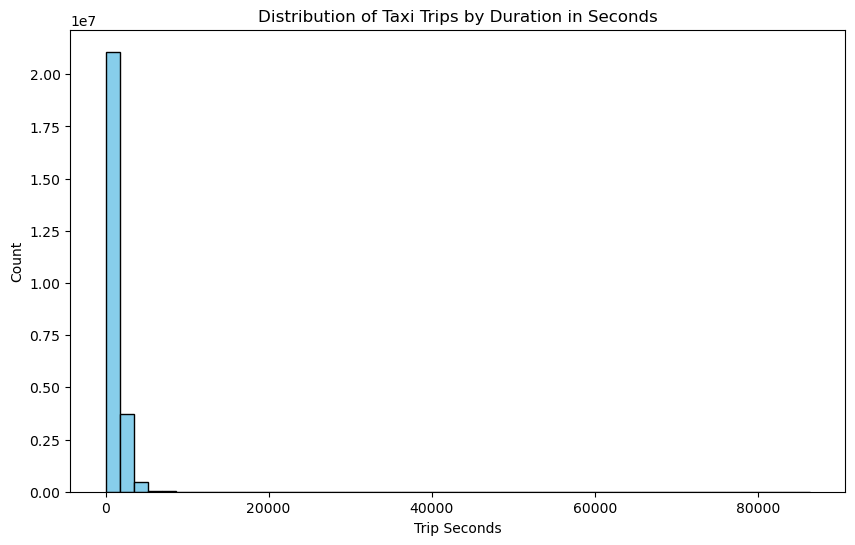

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(trip_in_seconds, bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Trip Seconds")
plt.ylabel("Count")
plt.title("Distribution of Taxi Trips by Duration in Seconds")
plt.show()

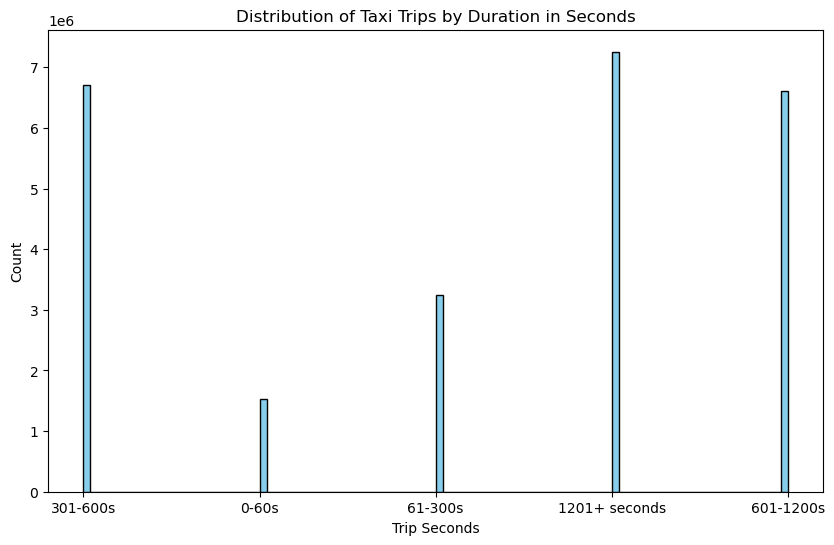

In [18]:
from pyspark.sql.functions import when
time_bucket = taxi_trip.withColumn("time_bucket", \
                    when(col("trip_seconds") <= 30, "0-60s")\
                   .when((col("trip_seconds") > 30) & (col("trip_seconds") <= 60), "0-60s")\
                   .when((col("trip_seconds") > 60) & (col("trip_seconds") <= 300), "61-300s")\
                   .when((col("trip_seconds") > 300) & (col("trip_seconds") <= 600), "301-600s")\
                   .when((col("trip_seconds") > 600) & (col("trip_seconds") <= 1200), "601-1200s")\
                   .otherwise("1201+ seconds"))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(time_bucket.select(col("time_bucket")).toPandas(), bins=100, color="skyblue", edgecolor="black")
plt.xlabel("Trip Seconds")
plt.ylabel("Count")
plt.title("Distribution of Taxi Trips by Duration in Seconds")
plt.show()